In [13]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), # нормализация и перевод в тензор 
])
train_dataset = datasets.CIFAR10('./data', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=False, transform=transform)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# ДЗ 1. Вариант 4, 6

Вариант 4. Сравнение GAP и Flatten  
Цель: Понимание различий между Flatten и Global Average Pooling.   
* Спроектируйте сеть с 3 свёрточными слоями, после которых выходной тензор (batch, 128, 8, 8).
* Условие: Реализуйте два варианта классификации:
        1. Flatten → Linear  
        2. Global Average Pooling → Linear   
* Эксперимент: Обучите оба варианта на данных и сравните дисперсию выходных активаций перед финальным слоем.


* out_channels – число выходных каналов (обязательный параметр). Количество ядер (фильтров), которые будут применяться к входным тензорам.
* in_channels – число каналов во входном тензоре (обязательный параметр). Если объявляется первый сверточный слой, то на его вход может подаваться полноцветное изображение в формате RGB, то есть, трехканальное.
* kernel_size – размер ядра (фильтра). 
* stride=1 – шаг сканирования (необязательный параметр). 
* padding=0 – расширение входного тензора по осям  
Входные изображения 32*32  
stride=1
padding=1  

In [3]:
import torch.nn.functional as F

In [18]:
class TestFlattenModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # 32, 32, 32
        self.pool = nn.MaxPool2d(2, 2) # 32, 16, 16
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 64, 16, 16
        # 64, 8, 8 при повторном применении  MaxPool2d
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # 128, 8, 8
        self.relu = nn.ReLU()
        # развернем тензоры в один вектор
        self.flatten = nn.Flatten(1) # 128 * 8 * 8
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        f_var = F.relu(x) 
        # тут смотрим на диперсию
        x = self.fc2(f_var)
        return x, f_var



Для Flatten(): [128, 8, 8]->128*8*8   
Для GAP: [128, 8, 8]->[128, 1, 1]  

In [22]:
class TestGAPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # 32, 32, 32
        self.pool = nn.MaxPool2d(2, 2) # 32, 16, 16
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 64, 16, 16
        # 64, 8, 8 при повторном применении  MaxPool2d
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # 128, 8, 8
        self.relu = nn.ReLU()
        # развернем тензоры в один вектор
        self.gap = nn.AdaptiveAvgPool2d(1) # 128, 1, 1
        self.fc1 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.gap(x) # 128, 1, 1
        f_var = x.view(x.size(0), -1) # 128
        # тут смотрим на диперсию
        x = self.fc1(f_var)
        return x, f_var



Цикл обучения

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


In [24]:
# Цикл обучения
model = TestFlattenModel()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
variances_epoch = []
epochs = 20
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        variances = []
        optimizer.zero_grad() # обнуляем градиенты
        outputs, f_var = model(images)
        
        loss = criterion(outputs, labels)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        variances.append(f_var.detach())
    # объединяем все из бачей
    all_var_batch = torch.cat(variances, dim=0)  
    mean_all_var_batch = all_var_batch.var(dim=0).mean()
    variances_epoch.append(mean_all_var_batch.item())
    print(f'Дисперсия: {mean_all_var_batch.item()}')
    print(f'loss: {sum(train_losses)/ len(train_losses)}')
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {sum(train_losses)/ len(train_losses)}')


100%|██████████| 782/782 [00:35<00:00, 21.84it/s]


Дисперсия: 1.29059898853302
loss: 1.474385380744934
Epoch [1/20], Loss: 1.474385380744934


100%|██████████| 782/782 [00:35<00:00, 21.85it/s]


Дисперсия: 1.8886237144470215
loss: 1.2792528867721558
Epoch [2/20], Loss: 1.2792528867721558


100%|██████████| 782/782 [00:35<00:00, 22.03it/s]


Дисперсия: 1.8413084745407104
loss: 1.1545398235321045
Epoch [3/20], Loss: 1.1545398235321045


100%|██████████| 782/782 [00:35<00:00, 21.78it/s]


Дисперсия: 2.1102232933044434
loss: 1.0583951473236084
Epoch [4/20], Loss: 1.0583951473236084


100%|██████████| 782/782 [00:35<00:00, 21.92it/s]


Дисперсия: 2.0461554527282715
loss: 0.9804429411888123
Epoch [5/20], Loss: 0.9804429411888123


100%|██████████| 782/782 [00:36<00:00, 21.28it/s]


Дисперсия: 1.9373739957809448
loss: 0.9140368103981018
Epoch [6/20], Loss: 0.9140368103981018


100%|██████████| 782/782 [00:36<00:00, 21.37it/s]


Дисперсия: 2.669264078140259
loss: 0.8535217046737671
Epoch [7/20], Loss: 0.8535217046737671


100%|██████████| 782/782 [00:37<00:00, 21.07it/s]


Дисперсия: 3.204991579055786
loss: 0.7984945178031921
Epoch [8/20], Loss: 0.7984945178031921


100%|██████████| 782/782 [00:37<00:00, 21.09it/s]


Дисперсия: 4.743518829345703
loss: 0.7469671368598938
Epoch [9/20], Loss: 0.7469671368598938


100%|██████████| 782/782 [00:37<00:00, 21.08it/s]


Дисперсия: 4.165380477905273
loss: 0.698860764503479
Epoch [10/20], Loss: 0.698860764503479


100%|██████████| 782/782 [00:37<00:00, 21.03it/s]


Дисперсия: 4.852662086486816
loss: 0.6547947525978088
Epoch [11/20], Loss: 0.6547947525978088


100%|██████████| 782/782 [00:36<00:00, 21.28it/s]


Дисперсия: 8.791662216186523
loss: 0.6145808100700378
Epoch [12/20], Loss: 0.6145808100700378


100%|██████████| 782/782 [00:37<00:00, 20.72it/s]


Дисперсия: 6.90703010559082
loss: 0.5780071020126343
Epoch [13/20], Loss: 0.5780071020126343


100%|██████████| 782/782 [00:36<00:00, 21.45it/s]


Дисперсия: 8.488430976867676
loss: 0.5451217889785767
Epoch [14/20], Loss: 0.5451217889785767


100%|██████████| 782/782 [00:36<00:00, 21.40it/s]


Дисперсия: 8.136369705200195
loss: 0.5155957937240601
Epoch [15/20], Loss: 0.5155957937240601


100%|██████████| 782/782 [00:37<00:00, 21.11it/s]


Дисперсия: 11.676102638244629
loss: 0.48967108130455017
Epoch [16/20], Loss: 0.48967108130455017


100%|██████████| 782/782 [00:37<00:00, 21.07it/s]


Дисперсия: 12.993762969970703
loss: 0.46583864092826843
Epoch [17/20], Loss: 0.46583864092826843


100%|██████████| 782/782 [00:36<00:00, 21.36it/s]


Дисперсия: 10.541089057922363
loss: 0.44466856122016907
Epoch [18/20], Loss: 0.44466856122016907


100%|██████████| 782/782 [00:36<00:00, 21.41it/s]


Дисперсия: 14.171013832092285
loss: 0.4251762926578522
Epoch [19/20], Loss: 0.4251762926578522


100%|██████████| 782/782 [00:37<00:00, 20.87it/s]


Дисперсия: 13.485845565795898
loss: 0.40775159001350403
Epoch [20/20], Loss: 0.40775159001350403


In [25]:
# Цикл обучения
model = TestGAPModel()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
variances_epoch = []
epochs = 20
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        variances = []
        optimizer.zero_grad() # обнуляем градиенты
        outputs, f_var = model(images)
        
        loss = criterion(outputs, labels)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        variances.append(f_var.detach())
    # объединяем все из бачей
    all_var_batch = torch.cat(variances, dim=0)  
    mean_all_var_batch = all_var_batch.var(dim=0).mean()
    variances_epoch.append(mean_all_var_batch.item())
    print(f'Дисперсия: {mean_all_var_batch.item()}')
    print(f'loss: {sum(train_losses)/ len(train_losses)}')
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {sum(train_losses)/ len(train_losses)}')


100%|██████████| 782/782 [00:30<00:00, 25.87it/s]


Дисперсия: 0.1839188188314438
loss: 1.819414496421814
Epoch [1/20], Loss: 1.819414496421814


100%|██████████| 782/782 [00:30<00:00, 25.82it/s]


Дисперсия: 0.32825538516044617
loss: 1.6708569526672363
Epoch [2/20], Loss: 1.6708569526672363


100%|██████████| 782/782 [00:30<00:00, 25.89it/s]


Дисперсия: 0.17103132605552673
loss: 1.5799732208251953
Epoch [3/20], Loss: 1.5799732208251953


100%|██████████| 782/782 [00:30<00:00, 25.84it/s]


Дисперсия: 0.2442135214805603
loss: 1.5153275728225708
Epoch [4/20], Loss: 1.5153275728225708


100%|██████████| 782/782 [00:30<00:00, 25.87it/s]


Дисперсия: 0.23563189804553986
loss: 1.4643099308013916
Epoch [5/20], Loss: 1.4643099308013916


100%|██████████| 782/782 [00:30<00:00, 25.88it/s]


Дисперсия: 0.3124702274799347
loss: 1.420555591583252
Epoch [6/20], Loss: 1.420555591583252


100%|██████████| 782/782 [00:30<00:00, 25.77it/s]


Дисперсия: 0.33223986625671387
loss: 1.381798505783081
Epoch [7/20], Loss: 1.381798505783081


100%|██████████| 782/782 [00:30<00:00, 25.65it/s]


Дисперсия: 0.2847999334335327
loss: 1.3469676971435547
Epoch [8/20], Loss: 1.3469676971435547


100%|██████████| 782/782 [00:30<00:00, 25.53it/s]


Дисперсия: 0.34313100576400757
loss: 1.3159699440002441
Epoch [9/20], Loss: 1.3159699440002441


100%|██████████| 782/782 [00:30<00:00, 25.28it/s]


Дисперсия: 0.28098469972610474
loss: 1.2879396677017212
Epoch [10/20], Loss: 1.2879396677017212


100%|██████████| 782/782 [00:30<00:00, 25.27it/s]


Дисперсия: 0.3731354773044586
loss: 1.261986494064331
Epoch [11/20], Loss: 1.261986494064331


100%|██████████| 782/782 [00:31<00:00, 25.19it/s]


Дисперсия: 0.3626006841659546
loss: 1.2384617328643799
Epoch [12/20], Loss: 1.2384617328643799


100%|██████████| 782/782 [00:31<00:00, 25.09it/s]


Дисперсия: 0.4937879145145416
loss: 1.216554880142212
Epoch [13/20], Loss: 1.216554880142212


100%|██████████| 782/782 [00:30<00:00, 25.34it/s]


Дисперсия: 0.40814974904060364
loss: 1.1960397958755493
Epoch [14/20], Loss: 1.1960397958755493


100%|██████████| 782/782 [00:30<00:00, 25.32it/s]


Дисперсия: 0.433280885219574
loss: 1.1770787239074707
Epoch [15/20], Loss: 1.1770787239074707


100%|██████████| 782/782 [00:31<00:00, 25.15it/s]


Дисперсия: 0.4846923351287842
loss: 1.1595155000686646
Epoch [16/20], Loss: 1.1595155000686646


100%|██████████| 782/782 [00:30<00:00, 25.29it/s]


Дисперсия: 0.43745237588882446
loss: 1.1429680585861206
Epoch [17/20], Loss: 1.1429680585861206


100%|██████████| 782/782 [00:30<00:00, 25.37it/s]


Дисперсия: 0.3714275360107422
loss: 1.1271589994430542
Epoch [18/20], Loss: 1.1271589994430542


100%|██████████| 782/782 [00:30<00:00, 25.32it/s]


Дисперсия: 0.3316091299057007
loss: 1.1121172904968262
Epoch [19/20], Loss: 1.1121172904968262


100%|██████████| 782/782 [00:30<00:00, 25.43it/s]


Дисперсия: 0.4070410430431366
loss: 1.0978425741195679
Epoch [20/20], Loss: 1.0978425741195679


Дисперсия GAP ~ 0.407, усреднили каждый из 128 каналов в одно число -> снизили влияние больших отклонений (если они были). 
Дисперсия Flatten ~14.0. Есть слой с большим количеством весов 128*8*8 (которые потом сжимаются в 128).Большая дисперсия.

### Вариант 6. Использование разных типов пулинга

Цель: Сравнение MaxPool и Global Average Pooling.

* Спроектируйте сеть для входа (3, 64, 64) и выхода (32, 8, 8).
* Условие: В сети обязательно должны быть и MaxPool2d, и AdaptiveAvgPool2d.
* Эксперимент: Сравните выходы после MaxPool и GAP на одном и том же случайном тензоре, визуализируйте карты признаков и среднее значение активаций.

In [31]:
class TestGAPolingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) 
        self.relu = nn.ReLU()
        # GAP в 8*8
        self.gap = nn.AdaptiveAvgPool2d((8,8))

    def forward(self, x):
        # 3, 64, 64
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # 8, 32, 32

        x = self.conv2(x)
        # 16, 32, 32
        x = self.relu(x)
        x = self.pool(x)
        # 16, 16, 16

        x = self.conv3(x)
        # 32, 16, 16
        x = self.relu(x)

        x_gap = self.gap(x)
        # 32, 8, 8
        x_maxpooling = self.pool(x)
        return x, x_gap, x_maxpooling



In [34]:
model = TestGAPolingModel()
model.eval()
test_input = torch.randn(1, 3, 64, 64) # (Batch=1, C=3, H=64, W=64)
output, x_gap, x_maxpoolin = model(test_input)
print(model)

TestGAPolingModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (gap): AdaptiveAvgPool2d(output_size=(8, 8))
)


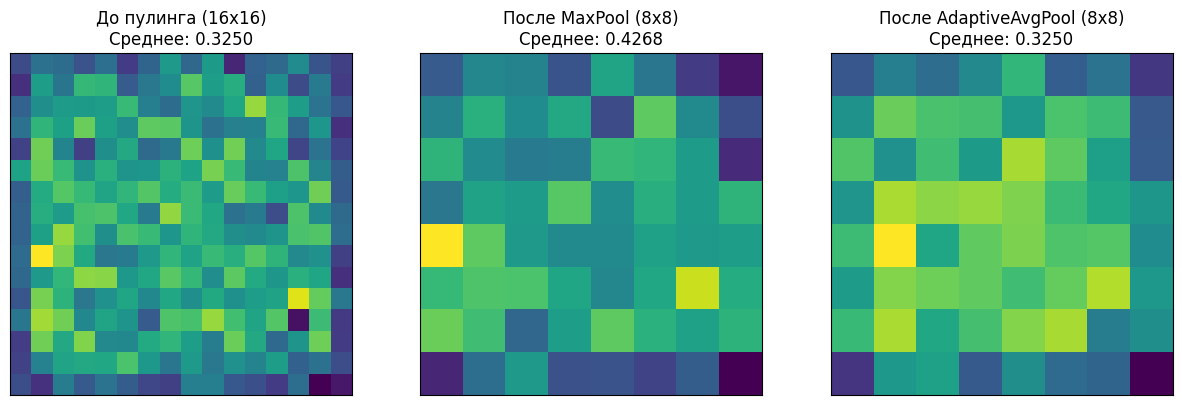

In [35]:
map_before = output.detach().cpu()[0, 0] # (16, 16)
map_max = x_maxpoolin.detach().cpu()[0, 0]       # (8, 8)
map_avg = x_gap.detach().cpu()[0, 0]       # (8, 8)
# среднее активации
mean_before = map_before.mean().item()
mean_max = map_max.mean().item()
mean_avg = map_avg.mean().item()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.imshow(map_before, cmap='viridis')
ax1.set_title(f"До пулинга (16x16)\nСреднее: {mean_before:.4f}")
ax1.set_xticks([]); ax1.set_yticks([])

ax2.imshow(map_max, cmap='viridis')
ax2.set_title(f"После MaxPool (8x8)\nСреднее: {mean_max:.4f}")
ax2.set_xticks([]); ax2.set_yticks([])

ax3.imshow(map_avg, cmap='viridis')
ax3.set_title(f"После AdaptiveAvgPool (8x8)\nСреднее: {mean_avg:.4f}")
ax3.set_xticks([]); ax3.set_yticks([])

plt.show()

MaxPool стремится сохранить наиболее значимые активации, что привело к более контрастным и резким картам признаков.

AdaptiveAvgPool (GAP) усредняет активации, карты признаков более сглаженны и менее контрастными, а среднее значение активаций после GAP ближе к среднему значению до пулинга, чем MaxPool.